In [0]:
import xgboost as xgb
import pandas as pd
# from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
from sklearn import preprocessing, pipeline, metrics
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate, cross_val_score
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error

from scipy import sparse
%matplotlib inline

grid_search: GridSearchCV \\
cross_validation: cross_validate

In [0]:
def log_mae(labels,preds,lift=200):
    return mean_absolute_error(np.exp(labels)-lift, np.exp(preds)-lift)

def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 


log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
    ##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("params:\n")
    print(model.cv_results_.__getitem__('params'))
    print("mean test scores:\n")
    print(model.cv_results_.__getitem__('mean_test_score'))
    print("std test scores:\n")
    print(model.cv_results_.__getitem__('std_test_score'))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    # print("Scores:", model.grid_scores_)
    print("**********************************************")
    
    return model

def xg_eval_mae(yhat, dtrain, lift=200):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-lift, np.exp(yhat)-lift)

def xgb_logregobj(preds, dtrain):
    con = 2
    labels = dtrain.get_label()
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess


def search_model_mae (train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                          param_grid = param_grid,
                          scoring    = 'neg_mean_absolute_error',
                          verbose    = 10,
                          n_jobs  = n_jobs,
                          iid        = True,
                          refit    = refit,
                          cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    # print("Scores:", model.grid_scores_)
    return model

## Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!cp -r /content/drive/My\ Drive/Kaggle_Allstate/data/train.csv /home/

In [0]:
!cp -r /content/drive/My\ Drive/Kaggle_Allstate/data/test.csv /home/

In [0]:
# Load data
start = time.time() 
train_data = pd.read_csv('/data/train.csv')
train_size=train_data.shape[0]
print ("Loading train data finished in %0.3fs" % (time.time() - start))        

test_data = pd.read_csv('/data/test.csv')
print ("Loading test data finished in %0.3fs" % (time.time() - start))

Loading train data finished in 2.776s
Loading test data finished in 4.473s


In [0]:
train_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Merge train and test

In [0]:
full_data=pd.concat([train_data
                       ,test_data])
del( train_data, test_data)
print ("Full Data set created.")

Full Data set created.


## Group features

In [0]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
num_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
num_cols.remove('id')
num_cols.remove('loss')

print ("Categorical features:", cat_cols)
print ( "Numerica features:", num_cols)
print ( "ID: %s, target: %s" %( id_col, target_col))

Categorical features: ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat1

In [0]:
LBL = preprocessing.LabelEncoder()
start=time.time()
for cat_col in cat_cols:
#     print ("Factorize feature %s" % (cat))
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 18.921697 seconds


In [0]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)

## it should be (313864, 1176)

One-hot-encoding finished in 3.006921 seconds
(313864, 1176)


In [0]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[num_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

cont2    -0.311146
cont3    -0.007023
cont14    0.250673
cont11    0.281139
cont12    0.291997
cont10    0.352116
cont13    0.376138
cont4     0.417559
cont6     0.458413
cont1     0.513205
cont8     0.673237
cont5     0.679610
cont7     0.825889
cont9     1.067247
dtype: float64


In [0]:
skewed_cols = skewed_cols[skewed_cols > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

In [0]:
SSL = preprocessing.StandardScaler()
# for num_col in num_cols:
#     full_data[num_col] = full_data[num_col].values.reshape(-1, 1)
#     full_data[num_col] = SSL.fit_transform(full_data[num_col])

full_data[num_cols] = SSL.fit_transform(full_data[num_cols])

In [0]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[num_cols])).tocsr()
print (full_data_sparse.shape)

(313864, 1190)


In [0]:
shift = 200
full_cols = cat_cols + num_cols
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values

In [0]:
# # Initialize data
# lift = 200

# full_cols = num_cols + cat_cols
# train_x = full_data[full_cols][:train_size].values
# test_x = full_data[full_cols][train_size:].values
# train_y = np.log(full_data[:train_size].loss.values + lift)
# ID = full_data.id[:train_size].values

In [0]:
print(train_x.shape)
print(test_x.shape)

(188318, 1190)
(125546, 1190)


## gridresearch model

In [0]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [0]:
# time consuming, use gpu to tune
param_grid = {'objective':[logregobj],
              'learning_rate':[0.01, 0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1137.840, total=  53.3s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.3s remaining:    0.0s


[12:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1141.557, total=  52.6s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[12:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1137.325, total=  52.6s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s


[12:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.01, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1136.673, total=  53.2s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s


[12:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1134.393, total=  50.8s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s


[12:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1139.094, total=  51.0s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.2min remaining:    0.0s


[12:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1134.547, total=  52.7s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.1min remaining:    0.0s


[12:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1133.511, total=  52.4s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.0min remaining:    0.0s


[12:53:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1140.857, total=  51.9s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.8min remaining:    0.0s


[12:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1146.169, total=  51.7s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78 
[12:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x7f2efe02c048>, seed=1234, subsample=0.78, score=-1139.953, total=  51.4s
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_chi

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 17.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[13:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
params:

[{'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f2efe02c048>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f2efe02c048>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.04, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x7f2efe02c048>, 'seed': 1234, 'subsample': 0.78}, {'colsample_bytree': 0.67, 'gamma': 0.9, 'learning_rate': 0.06, 'max_depth': 9, 'min_child_weight': 50, 'n_estimators': 1500, 'nthread': -1, 'objective': <function logregobj at 0x

In [0]:

# here just an example, please use the optimal parameters from last gridsearch cell
rgr = xgb.XGBRegressor(tree_method='gpu_hist',
                       gpu_id=0,
                      seed = 1234, 
                      learning_rate = 0.02, # smaller, better results, more time
                      n_estimators = 1500, # Number of boosted trees to fit. 
                      max_depth=9, # the maximum depth of a tree
                      min_child_weight=50,
                      colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                      subsample=0.78, # the fraction of observations to be randomly samples for each tree
                      gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                      nthread = -1, # Number of parallel threads used to run xgboost.
                      silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

[14:09:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.67, gamma=0.9, gpu_id=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=9, min_child_weight=50, missing=None, n_estimators=1500,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
             silent=False, subsample=0.78, tree_method='gpu_hist', verbosity=1)

In [0]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("/data/sub.csv", index=False)
print ("Submission created.")

Submission created.


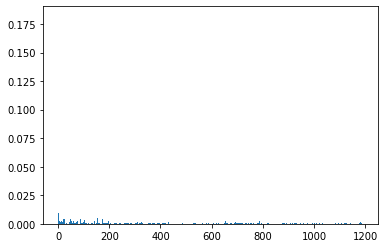

In [0]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

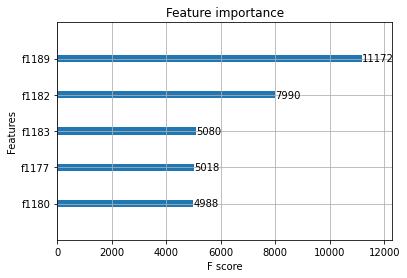

In [0]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [0]:
np.argsort(rgr.feature_importances_)

array([ 594,  467,  471, ..., 1047, 1051, 1053])

## Parameter tuning
### XGBoost manual greedy tuning 

xgb max_depth must be >=0 


In [0]:
from sklearn.model_selection import KFold,StratifiedKFold
import copy
kfolds = 5
random_state = 42

# skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=random_state)
skf = KFold(n_splits=kfolds, random_state=1234)
skf_ids = list(skf.split(train_y))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
default_xgb_params = {}
default_xgb_params["learning_rate"] = 0.05
default_xgb_params["metrics"] = 'rmse'
default_xgb_params["subsample"] = 1
default_xgb_params["seed"] = 1234
default_xgb_params["objective"] = 'reg:squarederror'
default_xgb_params["tree_method"] = 'gpu_hist'
default_xgb_params["gpu_id"] = 0


params_xgb_space = {}
params_xgb_space['max_leaves'] = [3, 7, 15, 31, 63, 127, 255] # the performance of =3 is equalt to others 
params_xgb_space['max_depth'] = [3 ,4 ,5 ,6 ,7 ,8] 
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_xgb_space['subsample'] = [0.2, 0.4, 0.6, 0.8, 1]
params_xgb_space['min_child_weight'] = [1, 5, 10, 30, 100]
params_xgb_space['lambda'] = [0, 0.01, 0.1, 1, 10, 100]
params_xgb_space['alpha'] = [0, 0.01, 0.1, 1, 10, 100]

In [0]:
greater_is_better = False

best_xgb_params = copy.copy(default_xgb_params)

for p in params_xgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        xgb_cv = xgb.cv(params,
                        xgb.DMatrix(train_x,
                                    label=train_y
                                    ),
                        num_boost_round=100000,
                        nfold=kfolds,
                        folds=list(skf.split(train_y)),
                        stratified=False,
                        early_stopping_rounds=50,
                        verbose_eval=500)

        best_xgb_score = min(xgb_cv['test-rmse-mean'])
        best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))
        scores.append([v, best_xgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_xgb_params)


 Tuning parameter max_leaves in [3, 7, 15, 31, 63, 127, 255]

    max_leaves: 3
[0]	train-rmse:6.97233+0.00038087	test-rmse:6.97235+0.00171519
[500]	train-rmse:0.507721+0.000434257	test-rmse:0.508607+0.00176234
[1000]	train-rmse:0.497247+0.000384104	test-rmse:0.498502+0.00188388
[1500]	train-rmse:0.493531+0.00031482	test-rmse:0.495256+0.00198871
[2000]	train-rmse:0.491486+0.000318544	test-rmse:0.493565+0.00204347
[2500]	train-rmse:0.489996+0.000341298	test-rmse:0.492374+0.00205447
[3000]	train-rmse:0.48884+0.000404373	test-rmse:0.491515+0.00209161
[3500]	train-rmse:0.487611+0.000619928	test-rmse:0.490569+0.00201428
[4000]	train-rmse:0.486636+0.000579663	test-rmse:0.489881+0.00211701
[4500]	train-rmse:0.485912+0.000651174	test-rmse:0.489394+0.00213503
[5000]	train-rmse:0.485276+0.000671661	test-rmse:0.488979+0.00205816
[5500]	train-rmse:0.484565+0.000668323	test-rmse:0.488482+0.00193314
[6000]	train-rmse:0.484025+0.000650182	test-rmse:0.488138+0.00195439
[6500]	train-rmse:0.483331+0.00

In [0]:
print ('\n Best manually tuned parameters:', best_xgb_params)


 Best manually tuned parameters: {'learning_rate': 0.05, 'metrics': 'rmse', 'subsample': 0.8, 'seed': 1234, 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'max_leaves': 127, 'max_depth': 7, 'gamma': 0, 'colsample_bytree': 0.1, 'min_child_weight': 100, 'lambda': 100, 'alpha': 10}


## Automated tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance.

In [0]:
!pip install bayesian-optimization

In [0]:
from bayes_opt import BayesianOptimization

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
def xgb_evaluate(
    max_leaves,
    max_depth,
    min_child_weight,
    gamma,
    colsample_bytree,
    subsample,
    lambda_1,
    alpha
):
    params = dict()
    params['objective'] = 'reg:squarederror'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['max_leaves'] = int(max_leaves)
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = gamma
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['lambda'] = lambda_1
    params['alpha'] = alpha
    params["metric"] = 'rmse'
    params["tree_method"] = 'gpu_hist'
    params["gpu_id"] = 0

    xgb_cv = xgb.cv(params,
                xgb.DMatrix(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=list(skf.split(train_y)),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

    best_xgb_score = min(xgb_cv['test-rmse-mean'])
    best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_xgb_score, best_xgb_iteration))

    return -best_xgb_score

In [0]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

xgb_BO = BayesianOptimization(xgb_evaluate,
                              {
                                  'max_leaves': (7, 31),
                                  'max_depth': (7, 31),
                                  'min_child_weight': (0, 2),
                                  'gamma': (0, 5),
                                  'colsample_bytree': (0.3, 0.6),
                                  'subsample': (0.9, 1),
                                  'lambda_1': (0, 1),
                                  'alpha': (0, 1)
                              }
                              )

logger = JSONLogger(path="/content/drive/My Drive/Kaggle_Allstate/data/logs_gpu.json")
xgb_BO.subscribe(Events.OPTIMIZATION_STEP, logger)

In [0]:
xgb_BO.maximize(init_points=5, n_iter=40) 
# in the competition, we should use more than 25, below we use 6 points as example. 
# xgb_BO.maximize(init_points=3, n_iter=3)

[0]	train-rmse:6.97233+0.000378053	test-rmse:6.97232+0.00161649
[500]	train-rmse:0.470635+0.000545791	test-rmse:0.481696+0.00202751
[1000]	train-rmse:0.459975+0.000459702	test-rmse:0.478801+0.00213447
[1500]	train-rmse:0.452288+0.000447315	test-rmse:0.477866+0.00220792
[2000]	train-rmse:0.445671+0.000469774	test-rmse:0.477504+0.00221853
, best_score: 0.477470, best_iteration: 2102
[0]	train-rmse:6.97241+0.000368375	test-rmse:6.97242+0.00164847
[500]	train-rmse:0.469116+0.000575465	test-rmse:0.481555+0.00206038
[1000]	train-rmse:0.457738+0.000469362	test-rmse:0.478779+0.00218331
[1500]	train-rmse:0.449586+0.000467544	test-rmse:0.47799+0.00221229
[2000]	train-rmse:0.442585+0.000466965	test-rmse:0.477685+0.00225143
, best_score: 0.477573, best_iteration: 2346
[0]	train-rmse:6.97199+0.000377748	test-rmse:6.97198+0.00170074
[500]	train-rmse:0.469353+0.000625262	test-rmse:0.48161+0.00185947
[1000]	train-rmse:0.458241+0.000481047	test-rmse:0.478956+0.00207415
[1500]	train-rmse:0.450201+0.0004

In [0]:
xgb_BO.res

[{'params': {'alpha': 0.9443408033988769,
   'colsample_bytree': 0.3558431609964596,
   'gamma': 4.696188321837841,
   'lambda_1': 0.6518433972257632,
   'max_depth': 17.312640079846492,
   'max_leaves': 27.541824872093443,
   'min_child_weight': 0.7528371837200969,
   'subsample': 0.9077252918981312},
  'target': -0.4774698},
 {'params': {'alpha': 0.6137969281145833,
   'colsample_bytree': 0.31365474212352024,
   'gamma': 4.151448278236447,
   'lambda_1': 0.35034786633150883,
   'max_depth': 18.68806955200861,
   'max_leaves': 30.809364365330705,
   'min_child_weight': 1.544144283558467,
   'subsample': 0.948846066577156},
  'target': -0.47757259999999996},
 {'params': {'alpha': 0.7680841123394783,
   'colsample_bytree': 0.5262847718961265,
   'gamma': 1.32858144342245,
   'lambda_1': 0.13037813495797712,
   'max_depth': 24.604570279921695,
   'max_leaves': 27.63622000589335,
   'min_child_weight': 0.5126015836326645,
   'subsample': 0.9429597651457532},
  'target': -0.478016800000000

In [0]:
xgb_BO_scores = pd.DataFrame()
for dic in xgb_BO.res:
  param = dic['params']
  param = pd.DataFrame([param])
  xgb_BO_scores = pd.concat([xgb_BO_scores, param], ignore_index=True)

xgb_BO_scores

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample
0,0.944341,0.355843,4.696188,0.651843,17.312640,27.541825,0.752837,0.907725
1,0.613797,0.313655,4.151448,0.350348,18.688070,30.809364,1.544144,0.948846
2,0.768084,0.526285,1.328581,0.130378,24.604570,27.636220,0.512602,0.942960
3,0.860323,0.444782,0.021859,0.361724,14.151384,27.120604,1.385639,0.929324
4,0.832833,0.501954,3.999739,0.582264,27.911008,28.413342,1.546214,0.946224
5,0.539332,0.592977,0.196068,0.655193,7.996903,7.053918,0.538716,0.908648
6,0.110324,0.340798,4.937913,0.856564,30.941440,7.470959,0.780997,0.904248
7,0.774069,0.447806,4.682184,0.165398,7.484805,30.986257,0.455631,0.935090
8,0.402336,0.322630,0.228134,0.433430,30.305566,30.453953,0.005969,0.927511
9,0.441223,0.511408,0.959607,0.949367,7.139717,30.826017,1.774899,0.914564


In [0]:
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res)['target']
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample,score
0,0.944341,0.355843,4.696188,0.651843,17.312640,27.541825,0.752837,0.907725,-0.477470
1,0.613797,0.313655,4.151448,0.350348,18.688070,30.809364,1.544144,0.948846,-0.477573
2,0.768084,0.526285,1.328581,0.130378,24.604570,27.636220,0.512602,0.942960,-0.478017
3,0.860323,0.444782,0.021859,0.361724,14.151384,27.120604,1.385639,0.929324,-0.477625
4,0.832833,0.501954,3.999739,0.582264,27.911008,28.413342,1.546214,0.946224,-0.477818


In [0]:
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,alpha,colsample_bytree,gamma,lambda_1,max_depth,max_leaves,min_child_weight,subsample,score
40,0.689365,0.308287,0.165608,0.736362,30.937494,30.886174,1.570292,0.933382,-0.477335
35,0.792661,0.311811,0.053720,0.836146,7.130656,30.715368,0.407117,0.904524,-0.477387
0,0.944341,0.355843,4.696188,0.651843,17.312640,27.541825,0.752837,0.907725,-0.477470
21,0.778909,0.375532,4.461670,0.997300,7.515387,30.952948,1.665992,0.960080,-0.477490
39,0.420596,0.411621,0.139340,0.833566,30.223293,30.873791,0.438479,0.901157,-0.477511


In [0]:
xgb_BO_scores.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/tuned_xgb_parameters_gpu.csv", index=False)

### Retrain the model with smaller learning rate 

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
params = xgb_BO_scores.iloc[0].to_dict()
best_auto_xgb_params = dict()
best_auto_xgb_params['objective'] = 'reg:squarederror'
best_auto_xgb_params["metric"] = 'rmse'
best_auto_xgb_params["tree_method"] = 'gpu_hist'
best_auto_xgb_params["gpu_id"] = 0
best_auto_xgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_auto_xgb_params['max_leaves'] = int(params['max_leaves'])    
best_auto_xgb_params['max_depth'] = int(params['max_depth'])    
best_auto_xgb_params['min_child_weight'] = int(params['min_child_weight'])
best_auto_xgb_params['gamma'] = params['gamma']     
best_auto_xgb_params['colsample_bytree'] = params['colsample_bytree']
best_auto_xgb_params['subsample'] = params['subsample']
best_auto_xgb_params['lambda'] = params['lambda_1']
best_auto_xgb_params['alpha'] = params['alpha']
best_auto_xgb_params['seed'] = 1234


print (best_auto_xgb_params)

xgb_cv = xgb.cv(best_auto_xgb_params,
            xgb.DMatrix(train_x,
                        label=train_y
                        ),
            num_boost_round=100000,
            nfold=kfolds,
            folds=list(skf.split(train_y)),
            stratified=False,
            early_stopping_rounds=50,
            verbose_eval=500)

best_xgb_score = min(xgb_cv['test-rmse-mean'])
best_xgb_iteration = len(xgb_cv['test-rmse-mean'])
print (', best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))

{'objective': 'reg:squarederror', 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'learning_rate': 0.01, 'max_leaves': 30, 'max_depth': 30, 'min_child_weight': 1, 'gamma': 0.16560750234327126, 'colsample_bytree': 0.3082872289501678, 'subsample': 0.9333823338214866, 'lambda': 0.7363621472291056, 'alpha': 0.6893647794118353, 'seed': 1234}
[0]	train-rmse:7.26358+0.000394456	test-rmse:7.26358+0.00160251
[500]	train-rmse:0.502699+0.000418735	test-rmse:0.505879+0.00184392
[1000]	train-rmse:0.483845+0.00045759	test-rmse:0.489541+0.00183452
[1500]	train-rmse:0.476802+0.000540656	test-rmse:0.484806+0.00187917
[2000]	train-rmse:0.472252+0.000573244	test-rmse:0.482347+0.0019262
[2500]	train-rmse:0.46882+0.00053982	test-rmse:0.480866+0.0019953
[3000]	train-rmse:0.466021+0.000535945	test-rmse:0.479908+0.00203895
[3500]	train-rmse:0.463573+0.000505705	test-rmse:0.479205+0.00207654
[4000]	train-rmse:0.461374+0.000486815	test-rmse:0.478675+0.0020993
[4500]	train-rmse:0.45937+0.000467675	test

## XGBosst blending function 

1. KFold.split()返回的是(train_idx, test_idx)，在旧版本中KFold()返回的是(train_idx, test_idx)


In [0]:
from sklearn.model_selection import StratifiedKFold, KFold 
import copy

In [0]:
def xgb_blend(xgb_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, train_y_dummy=None):
    """
    estimator: parameters 
    """
    print(f"Blend {len(xgb_params)} estimators for {kfolds} folds")
    skf = KFold(n_splits=kfolds, random_state=1234)
    skf_ids = list(skf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(xgb_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(xgb_params)))
    blend_scores = np.zeros ((kfolds,len(xgb_params)))
    best_rounds = np.zeros ((kfolds,len(xgb_params)))

    print("Start stacking")

    for j, est in enumerate(xgb_params):
        print("Stacking model", j+1, est)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print (f"Model {j+1} fold {i+1}")
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, est)

            if early_stopping_rounds == 0: 
                #without early stoping
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = xgb.train(params, 
                                  xgb.DMatrix(train_x_fold, 
                                              train_y_fold
                                              ),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                                  )
                val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold))
                socre = log_mae(val_y_fold, val_y_predict_fold, 200)
                print(f"Score for Model {j+1} fold {i+1}: {score}")
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x))
                print(f"Model {j+1} fold {i+1} finished in {time.time()-start} seconds.")
            else:
                valid_data = xgb.DMatrix(val_x_fold, val_y_fold)
                model = xgb.train(params,
                                  xgb.DMatrix(train_x_fold,
                                              train_y_fold
                                              ),
                                  evals=[(valid_data, 'valid')], 
                                  num_boost_round=10000000,
                                  early_stopping_rounds=early_stopping_rounds, 
                                  verbose_eval=500)
                best_iteration = model.best_iteration
                best_ntree_limit = model.best_ntree_limit
                best_rounds[i, j] = best_iteration
                print(f"best iteration: {best_iteration}")
                print(f"best score: {model.best_score}")
                val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold), ntree_limit=best_ntree_limit)
                score = log_mae(val_y_fold, val_y_predict_fold, 200)
                print(f"Score for Model {j+1} fold {i+1}: {score}")
                blend_scores[i, j] = score 
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x), ntree_limit=best_ntree_limit)
                print(f"Model {j+1} fold {i+1} finished in {time.time()-start}")

        test_blend_x[:, j]= test_blend_x_j / kfolds
        print(f"Score for model {j+1} is {np.mean(blend_scores[:, j])}")
    print(f"Socre for blended models is {np.mean(blend_scores)}")
    return train_blend_x, test_blend_x, blend_scores

### Select top 4 XGBoost models 

lgb vs xgb:
bagging_freq = Not have this feature \\
num_leaves = max_leaves \\
max_depth = max_depth \\
min_gain_to_split = gamma \\
feature_fraction = colsample_bytree \\
bagging_fraction = subsample \\
min_sum_hessian_in_leaf = min_child_weight \\
lambda_l2 = lambda \\
lambda_l1 = alpha \\

In [0]:
xgb_params = []
## Top 5 auto-tuned parameters
for i in range(4):
    params=dict()
    params['max_leaves'] = int(xgb_BO_scores['max_leaves'][i])
    params['max_depth'] = int(xgb_BO_scores['max_depth'][i])
    params['min_child_weight'] = int(xgb_BO_scores['min_child_weight'][i])
    params['gamma'] = xgb_BO_scores['gamma'][i]
    params['colsample_bytree'] = xgb_BO_scores['colsample_bytree'][i]
    params['subsample'] = xgb_BO_scores['subsample'][i]
    params['lambda_1'] = xgb_BO_scores['lambda_1'][i]
    params['alpha'] = int(xgb_BO_scores['alpha'][i])
    params['objective'] = 'reg:squarederror'
    params['learning_rate'] = 0.05
    params['num_boost_round']= best_xgb_iteration # use the result best_xgb_iteration from the cell Retrain the model with smaller learning rate, here use a example value 
    params['seed'] = 1234
    params["metric"] = 'rmse'
    params["tree_method"] = 'gpu_hist'
    params["gpu_id"] = 0
    xgb_params.append(params)

## Best manual-tuned parameters
xgb_params.append(best_xgb_params)    
print(xgb_params)

[{'max_leaves': 27, 'max_depth': 17, 'min_child_weight': 0, 'gamma': 4.696188321837841, 'colsample_bytree': 0.3558431609964596, 'subsample': 0.9077252918981312, 'lambda_1': 0.6518433972257632, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 11611, 'seed': 1234, 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0}, {'max_leaves': 30, 'max_depth': 18, 'min_child_weight': 1, 'gamma': 4.151448278236447, 'colsample_bytree': 0.31365474212352024, 'subsample': 0.948846066577156, 'lambda_1': 0.35034786633150883, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 11611, 'seed': 1234, 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0}, {'max_leaves': 27, 'max_depth': 24, 'min_child_weight': 0, 'gamma': 1.32858144342245, 'colsample_bytree': 0.5262847718961265, 'subsample': 0.9429597651457532, 'lambda_1': 0.13037813495797712, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 1

In [0]:
train_blend_x_xgb_ohe, test_blend_x_xgb_ohe, blend_scores_xgb_ohe = xgb_blend(xgb_params, train_x, train_y, test_x, 4, 1000)

Blend 5 estimators for 4 folds
Start stacking
Stacking model 1 {'max_leaves': 27, 'max_depth': 17, 'min_child_weight': 0, 'gamma': 4.696188321837841, 'colsample_bytree': 0.3558431609964596, 'subsample': 0.9077252918981312, 'lambda_1': 0.6518433972257632, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 11611, 'seed': 1234, 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0}
Model 1 fold 1
0 {'max_leaves': 27, 'max_depth': 17, 'min_child_weight': 0, 'gamma': 4.696188321837841, 'colsample_bytree': 0.3558431609964596, 'subsample': 0.9077252918981312, 'lambda_1': 0.6518433972257632, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 11611, 'seed': 1234, 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0]	valid-rmse:6.97003
Will train until valid-rmse hasn't improved in 1000 rounds.
[500]	valid-rmse:0.481303
[1000]	valid-rmse:0.478493
[1500]	valid-rmse:0.477661
[2000]	valid-rmse:0.477338
[2500]	valid-rmse:0.477442
Stopping. Best iteration:
[1923]	valid-rmse:0.477295

best iteration: 1923
best score: 0.477295
Score for Model 1 fold 1: 1142.9010680131807
Model 1 fold 1 finished in 62.28277015686035
Model 1 fold 2
1 {'max_leaves': 27, 'max_depth': 17, 'min_child_weight': 0, 'gamma': 4.696188321837841, 'colsample_bytree': 0.3558431609964596, 'subsample': 0.9077252918981312, 'lambda_1': 0.6518433972257632, 'alpha': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'num_boost_round': 11611, 'seed': 1234, 'metric': 'rmse', 'tree_method': 'gpu_hist', 'gpu_id': 0}
[0]	valid-rmse:6.97463
Will train until valid-rmse hasn't improved in 1000 rounds.
[500]	valid-rmse:0.481001
[1000]	valid-rmse:0.478194
[1500]	valid-rmse:0.477612
[2000]	valid-rmse:0.477429
[2500]	valid-rmse:0.477501
Stopp

In [0]:
print (np.mean(blend_scores_xgb_ohe,axis=0))
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_xgb_ohe_gpu.csv",train_blend_x_xgb_ohe, delimiter=",")
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_xgb_ohe_gpu.csv",test_blend_x_xgb_ohe, delimiter=",")

[1144.32087637 1144.32087637 1144.32087637 1144.32087637 1144.32087637]


In [0]:
blend_scores_xgb_ohe

array([[1142.90106801, 1142.90106801, 1142.90106801, 1142.90106801,
        1142.90106801],
       [1148.74341868, 1148.74341868, 1148.74341868, 1148.74341868,
        1148.74341868],
       [1142.85953119, 1142.85953119, 1142.85953119, 1142.85953119,
        1142.85953119],
       [1142.77948759, 1142.77948759, 1142.77948759, 1142.77948759,
        1142.77948759]])

## LightGBM tuning 

### Manual tuning 

In [0]:
!pip uninstall lightgbm

Uninstalling lightgbm-2.3.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/lightgbm
    /usr/local/lib/python3.6/dist-packages/lightgbm-2.3.2-py3.6.egg-info
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.3.2


In [0]:
%cd /content/

/content


In [0]:
!rm -r LightGBM/

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17509 (delta 0), reused 0 (delta 0), pack-reused 17505
Receiving objects: 100% (17509/17509), 11.91 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (12771/12771), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 15.53 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [0]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [0]:
import lightgbm as lgb

In [0]:
import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234
default_lgb_params["objective"] = "regression"
default_lgb_params['device'] = 'gpu'
# default_lgb_params['gpu_platform_id'] = 0
# default_lgb_params['gpu_device_id'] = 0

params_lgb_space = {}
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255]
params_lgb_space['max_depth'] = [3 ,4 ,5 ,6 ,7 ,8, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]
# params_lgb_space['objective'] = ['regression', 'regression_l1', 'poisson']



greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_x,train_y),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

        best_lgb_score = min(lgb_cv['rmse-mean'])
        best_lgb_iteration = len(lgb_cv['rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)


 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255]

    num_leaves: 3
[500]	cv_agg's rmse: 0.505839 + 0.00191511
[1000]	cv_agg's rmse: 0.496659 + 0.00204289
[1500]	cv_agg's rmse: 0.492759 + 0.00203624
[2000]	cv_agg's rmse: 0.49048 + 0.00207569
[2500]	cv_agg's rmse: 0.488903 + 0.00210408
[3000]	cv_agg's rmse: 0.487686 + 0.00204859
[3500]	cv_agg's rmse: 0.486779 + 0.0020033
[4000]	cv_agg's rmse: 0.486048 + 0.00202421
[4500]	cv_agg's rmse: 0.485457 + 0.00204797
[5000]	cv_agg's rmse: 0.484939 + 0.00208115
[5500]	cv_agg's rmse: 0.484511 + 0.00208058
[6000]	cv_agg's rmse: 0.484101 + 0.00211364
[6500]	cv_agg's rmse: 0.483767 + 0.00212561
[7000]	cv_agg's rmse: 0.48336 + 0.00205232
[7500]	cv_agg's rmse: 0.483085 + 0.00205272
[8000]	cv_agg's rmse: 0.482864 + 0.00206986
[8500]	cv_agg's rmse: 0.482666 + 0.00206528
[9000]	cv_agg's rmse: 0.482503 + 0.00206903
[9500]	cv_agg's rmse: 0.482375 + 0.00206197
[10000]	cv_agg's rmse: 0.482248 + 0.00203426
[10500]	cv_agg's rmse: 0.482114 + 0.002036

In [0]:
best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
best_lgb_params[p] = best_param_value
print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)

Best lambda_l1 is 0.01 with a score of 0.475085

 Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'device': 'gpu', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}


### Automated tuning


In [0]:
def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'rmse'

    lgb_cv = lgb.cv(params,
                    lgb.Dataset(train_x,
                                label=train_y
                                ),
                    num_boost_round=100000,
                    nfold=kfolds,
                    folds=skf.split(train_x, train_y),
                    early_stopping_rounds=50,
                    verbose_eval=500)

    best_lgb_score = min(lgb_cv['rmse-mean'])
    best_lgb_iteration = len(lgb_cv['rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                              {
                                  'num_leaves': (7, 31),
                                  'max_depth': (7, 31),
                                  'min_sum_hessian_in_leaf': (0, 2),
                                  'min_gain_to_split': (0, 5),
                                  'feature_fraction': (0.3, 0.6),
                                  'bagging_fraction': (0.9, 1),
                                  'lambda_l2': (0, 1),
                                  'lambda_l1': (0, 1)
                              }
                              )

lgb_BO.maximize(init_points=5, n_iter=40)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[500]	cv_agg's rmse: 0.484597 + 0.00193512
, best_score: 0.484563, best_iteration: 825
|  1        | -0.4846   |  0.9955   |  0.4315   |  0.3609   |  0.9566   |  29.35    |  2.322    |  1.869    |  17.27    |
[500]	cv_agg's rmse: 0.480458 + 0.00218518
[1000]	cv_agg's rmse: 0.480178 + 0.00217923
[1500]	cv_agg's rmse: 0.480105 + 0.00218394
, best_score: 0.480080, best_iteration: 1913
|  2        | -0.4801   |  0.9203   |  0.3006   |  0.1219   |  0.1827   |  12.92    |  0.7886   |  0.1555   |  22.41    |
[500]	cv_agg's rmse: 0.48386 + 0.00202926
[1000]	cv_agg's rmse: 0.483664 + 0.00202562
[1500]	cv_agg's rmse: 0.483589 + 0.0020208
[2000]	cv_agg's rmse: 0.483549 + 0.00202981
, best_score: 0.483529, best_iteration: 2346
|  3        | -0.4835   |  0.91

In [0]:
lgb_BO_scores = pd.DataFrame()
for dic in lgb_BO.res:
  param = dic['params']
  param = pd.DataFrame([param])
  lgb_BO_scores = pd.concat([lgb_BO_scores, param], ignore_index=True)

lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res)['target']
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/tuned_lgb_parameters_gpu.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
20,0.980568,0.303306,0.550268,0.029935,27.089429,0.002784,0.145851,30.808009,-0.476282
24,0.900711,0.307562,0.943830,0.569945,28.668160,0.005864,0.158714,27.967231,-0.476326
19,0.904914,0.443526,0.972553,0.434593,18.605972,0.007592,0.147021,30.662430,-0.476424
38,0.955465,0.323185,0.858551,0.890984,12.777574,0.014763,1.550804,30.968166,-0.476448
13,0.901150,0.335025,0.836701,0.065558,30.376536,0.022011,1.563845,30.618696,-0.476492


In [0]:
params = lgb_BO_scores.iloc[0].to_dict()
best_auto_lgb_params = dict()
best_auto_lgb_params['objective'] = 'regression'
best_auto_lgb_params["metric"] = 'rmse'
best_auto_lgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_auto_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_auto_lgb_params['max_depth'] = int(params['max_depth'])    
best_auto_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_auto_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_auto_lgb_params['feature_fraction'] = params['feature_fraction']
best_auto_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_auto_lgb_params['bagging_freq'] = 1
best_auto_lgb_params['lambda_l2'] = params['lambda_l2']
best_auto_lgb_params['lambda_l1'] = params['lambda_l1']
best_auto_lgb_params['seed'] = 1234


print (best_auto_lgb_params)


lgb_cv = lgb.cv(best_auto_lgb_params,
            lgb.Dataset(train_x,
                        label=train_y
                        ),
            num_boost_round=100000,
            nfold=kfolds,
            folds=skf.split(train_x,train_y),
            early_stopping_rounds=50,
            verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 30, 'max_depth': 27, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.0027838726568518712, 'feature_fraction': 0.30330552664662813, 'bagging_fraction': 0.9805677235689514, 'bagging_freq': 1, 'lambda_l2': 0.02993467470115463, 'lambda_l1': 0.5502676113750163, 'seed': 1234}
[500]	cv_agg's rmse: 0.493225 + 0.00171951
[1000]	cv_agg's rmse: 0.481638 + 0.00192038
[1500]	cv_agg's rmse: 0.478804 + 0.00200583
[2000]	cv_agg's rmse: 0.477905 + 0.00202181
[2500]	cv_agg's rmse: 0.477369 + 0.00203447
[3000]	cv_agg's rmse: 0.476991 + 0.00202457
[3500]	cv_agg's rmse: 0.476689 + 0.00202678
[4000]	cv_agg's rmse: 0.476468 + 0.00201119
[4500]	cv_agg's rmse: 0.476279 + 0.0020047
[5000]	cv_agg's rmse: 0.476129 + 0.00201517
[5500]	cv_agg's rmse: 0.475983 + 0.0020029
[6000]	cv_agg's rmse: 0.475851 + 0.00201055
[6500]	cv_agg's rmse: 0.475759 + 0.00201582
[7000]	cv_agg's rmse: 0.475687 + 0.00202182
[7500]	cv_agg's rmse: 0.4756

In [0]:
from sklearn.metrics import mean_squared_error

def lgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, train_y_dummy=None):

    skf = KFold(n_splits=kfolds,random_state=1234)
    skf_ids = list(skf.split(train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros ((kfolds,len(rgr_params)))

    print("Start stacking.")
    for j, params in enumerate(rgr_params):
        print("Stacking model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)
            
            
            if early_stopping_rounds==0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
            else:
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold
                                               ),
                                  valid_sets=[lgb.Dataset(val_x_fold, 
                                                val_y_fold
                                                         )],
                                  valid_names=['valid'],
                                  num_boost_round=10000000,
                                  early_stopping_rounds = early_stopping_rounds,
                                  verbose_eval=500
                                )
                best_iteration = model.best_iteration
                print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(val_x_fold, num_iteration=best_iteration)
                score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x, num_iteration=best_iteration)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))                
                
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores

In [0]:
lgb_params = []
## Top 5 auto-tuned parameters
for i in range(4):
    params=dict()
    params['num_leaves'] = int(lgb_BO_scores['num_leaves'][i])
    params['max_depth'] = int(lgb_BO_scores['max_depth'][i])
    params['min_sum_hessian_in_leaf'] = int(lgb_BO_scores['min_sum_hessian_in_leaf'][i])
    params['min_gain_to_split'] = lgb_BO_scores['min_gain_to_split'][i]
    params['feature_fraction'] = lgb_BO_scores['feature_fraction'][i]
    params['bagging_fraction'] = lgb_BO_scores['bagging_fraction'][i]
    params['bagging_freq'] = 1
    params['lambda_l2'] = lgb_BO_scores['lambda_l2'][i]
    params['lambda_l1'] = int(lgb_BO_scores['lambda_l1'][i])
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['num_boost_round']=best_lgb_iteration
    params['seed'] = 1234
    params["metric"] = 'rmse'
    params['device'] = 'gpu'
    lgb_params.append(params)

## Best manual-tuned parameters
lgb_params.append(best_lgb_params)    
print(lgb_params)

[{'num_leaves': 17, 'max_depth': 29, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.3216378457422437, 'feature_fraction': 0.4315001535921186, 'bagging_fraction': 0.995522553917235, 'bagging_freq': 1, 'lambda_l2': 0.9565641938921855, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}, {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}, {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 

In [0]:
train_blend_x_lgb_ohe, test_blend_x_lgb_ohe, blend_scores_lgb_ohe = lgb_rgr_stack(lgb_params, train_x, train_y, test_x, 4, early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Start stacking.
Stacking model 1 {'num_leaves': 17, 'max_depth': 29, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.3216378457422437, 'feature_fraction': 0.4315001535921186, 'bagging_fraction': 0.995522553917235, 'bagging_freq': 1, 'lambda_l2': 0.9565641938921855, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}
Model 1 fold 1
0 {'num_leaves': 17, 'max_depth': 29, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.3216378457422437, 'feature_fraction': 0.4315001535921186, 'bagging_fraction': 0.995522553917235, 'bagging_freq': 1, 'lambda_l2': 0.9565641938921855, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}
Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.484489
Early stopping, best iteration is:
[635]	valid's rmse: 0.484476
0.4844759335605612
Score for Model 1 fol

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.48404
Early stopping, best iteration is:
[758]	valid's rmse: 0.48402
0.4840199362595683
Score for Model 1 fold 2: 0.484020 
Model 1 fold 2 finished in 19 seconds.
Model 1 fold 3
2 {'num_leaves': 17, 'max_depth': 29, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.3216378457422437, 'feature_fraction': 0.4315001535921186, 'bagging_fraction': 0.995522553917235, 'bagging_freq': 1, 'lambda_l2': 0.9565641938921855, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.486367
Early stopping, best iteration is:
[938]	valid's rmse: 0.48632
0.48632006430177704
Score for Model 1 fold 3: 0.486320 
Model 1 fold 3 finished in 21 seconds.
Model 1 fold 4
3 {'num_leaves': 17, 'max_depth': 29, 'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 2.3216378457422437, 'feature_fraction': 0.4315001535921186, 'bagging_fraction': 0.995522553917235, 'bagging_freq': 1, 'lambda_l2': 0.9565641938921855, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.48486
Early stopping, best iteration is:
[493]	valid's rmse: 0.48486
0.4848596854356977
Score for Model 1 fold 4: 0.484860 
Model 1 fold 4 finished in 14 seconds.
Score for model 1 is 0.484919
Stacking model 2 {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}
Model 2 fold 1
0 {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.480565
[1000]	valid's rmse: 0.48034
[1500]	valid's rmse: 0.48026
Early stopping, best iteration is:
[1772]	valid's rmse: 0.480212
0.4802123776805648
Score for Model 2 fold 1: 0.480214 
Model 2 fold 1 finished in 37 seconds.
Model 2 fold 2
1 {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.479946
[1000]	valid's rmse: 0.479697
Early stopping, best iteration is:
[1410]	valid's rmse: 0.479647
0.47964729838958947
Score for Model 2 fold 2: 0.479647 
Model 2 fold 2 finished in 30 seconds.
Model 2 fold 3
2 {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.48204
[1000]	valid's rmse: 0.481792
[1500]	valid's rmse: 0.481711
Early stopping, best iteration is:
[1625]	valid's rmse: 0.481698
0.4816984813356717
Score for Model 2 fold 3: 0.481701 
Model 2 fold 3 finished in 33 seconds.
Model 2 fold 4
3 {'num_leaves': 22, 'max_depth': 12, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 0.7885742928896289, 'feature_fraction': 0.3005860158457473, 'bagging_fraction': 0.9202818625421475, 'bagging_freq': 1, 'lambda_l2': 0.18270342809299156, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.480486
[1000]	valid's rmse: 0.480272
[1500]	valid's rmse: 0.480201
Early stopping, best iteration is:
[1555]	valid's rmse: 0.48019
0.4801900756558205
Score for Model 2 fold 4: 0.480193 
Model 2 fold 4 finished in 31 seconds.
Score for model 2 is 0.480439
Stacking model 3 {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}
Model 3 fold 1
0 {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 'lambda_l1

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.484288
[1000]	valid's rmse: 0.484129
Early stopping, best iteration is:
[1309]	valid's rmse: 0.484096
0.4840959407595176
Score for Model 3 fold 1: 0.484099 
Model 3 fold 1 finished in 30 seconds.
Model 3 fold 2
1 {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.483331
[1000]	valid's rmse: 0.483147
Early stopping, best iteration is:
[1240]	valid's rmse: 0.483095
0.4830951658169097
Score for Model 3 fold 2: 0.483097 
Model 3 fold 2 finished in 28 seconds.
Model 3 fold 3
2 {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.485521
[1000]	valid's rmse: 0.485349
Early stopping, best iteration is:
[1370]	valid's rmse: 0.485256
0.4852560881827074
Score for Model 3 fold 3: 0.485256 
Model 3 fold 3 finished in 29 seconds.
Model 3 fold 4
3 {'num_leaves': 15, 'max_depth': 26, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 1.9659221466636223, 'feature_fraction': 0.5135254267026184, 'bagging_fraction': 0.9151811663109417, 'bagging_freq': 1, 'lambda_l2': 0.8489393304716284, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.484042
[1000]	valid's rmse: 0.483867
[1500]	valid's rmse: 0.483777
Early stopping, best iteration is:
[1545]	valid's rmse: 0.483768
0.4837683170783715
Score for Model 3 fold 4: 0.483768 
Model 3 fold 4 finished in 32 seconds.
Score for model 3 is 0.484055
Stacking model 4 {'num_leaves': 9, 'max_depth': 20, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.535170138877629, 'feature_fraction': 0.5019959113084462, 'bagging_fraction': 0.9594229817959025, 'bagging_freq': 1, 'lambda_l2': 0.48588842619015526, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}
Model 4 fold 1
0 {'num_leaves': 9, 'max_depth': 20, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.535170138877629, 'feature_fraction': 0.5019959113084462, 'bagging_fraction': 0.9594229817959025, 'bagging_freq': 1, 'lambda_l2': 0.48588842619015526, 'lambda_l1'

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.488531
Early stopping, best iteration is:
[792]	valid's rmse: 0.488458
0.48845812910045844
Score for Model 4 fold 1: 0.488458 
Model 4 fold 1 finished in 20 seconds.
Model 4 fold 2
1 {'num_leaves': 9, 'max_depth': 20, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.535170138877629, 'feature_fraction': 0.5019959113084462, 'bagging_fraction': 0.9594229817959025, 'bagging_freq': 1, 'lambda_l2': 0.48588842619015526, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.488168
Early stopping, best iteration is:
[599]	valid's rmse: 0.488121
0.4881210653384182
Score for Model 4 fold 2: 0.488121 
Model 4 fold 2 finished in 16 seconds.
Model 4 fold 3
2 {'num_leaves': 9, 'max_depth': 20, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.535170138877629, 'feature_fraction': 0.5019959113084462, 'bagging_fraction': 0.9594229817959025, 'bagging_freq': 1, 'lambda_l2': 0.48588842619015526, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.490484
[1000]	valid's rmse: 0.490333
Early stopping, best iteration is:
[1091]	valid's rmse: 0.490313
0.4903125258247788
Score for Model 4 fold 3: 0.490313 
Model 4 fold 3 finished in 23 seconds.
Model 4 fold 4
3 {'num_leaves': 9, 'max_depth': 20, 'min_sum_hessian_in_leaf': 0, 'min_gain_to_split': 4.535170138877629, 'feature_fraction': 0.5019959113084462, 'bagging_fraction': 0.9594229817959025, 'bagging_freq': 1, 'lambda_l2': 0.48588842619015526, 'lambda_l1': 0, 'objective': 'regression', 'learning_rate': 0.05, 'num_boost_round': 8035, 'seed': 1234, 'metric': 'rmse', 'device': 'gpu'}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[500]	valid's rmse: 0.489242
Early stopping, best iteration is:
[910]	valid's rmse: 0.489083
0.48908336297114624
Score for Model 4 fold 4: 0.489083 
Model 4 fold 4 finished in 20 seconds.
Score for model 4 is 0.488994
Stacking model 5 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'device': 'gpu', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}
Model 5 fold 1
0 {'learning_rate': 0.05, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'device': 'gpu', 'num_leaves': 127, 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 0.1, 'lambda_l1': 0.01}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration

In [0]:
print (np.mean(blend_scores_lgb_ohe,axis=0))
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_lgb_ohe_gpu.csv",train_blend_x_lgb_ohe, delimiter=",")
np.savetxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_lgb_ohe_gpu.csv",test_blend_x_lgb_ohe, delimiter=",")

[0.484919   0.48043868 0.48405513 0.48899384 0.47552694]


In [0]:
blend_scores_lgb_ohe

array([[0.48447593, 0.48021392, 0.48409873, 0.48845813, 0.47474076],
       [0.48401994, 0.47964733, 0.48309718, 0.48812107, 0.47540596],
       [0.48632006, 0.4817007 , 0.48525631, 0.49031282, 0.47709882],
       [0.48486008, 0.48019275, 0.48376832, 0.48908336, 0.47486223]])

In [0]:
type(train_blend_x_lgb_ohe)

numpy.ndarray

## stacking

In [0]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from numpy import genfromtxt

In [0]:
train_blend_x_xgb_ohe  = genfromtxt("/content/drive/My Drive/Kaggle_Allstate/data/train_blend_x_xgb_ohe_gpu.csv", delimiter=',')
test_blend_x_xgb_ohe  = genfromtxt("/content/drive/My Drive/Kaggle_Allstate/data/test_blend_x_xgb_ohe_gpu.csv", delimiter=',')

In [0]:
print  ("stacking.")
param_grid = {
    'alpha':[0,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,15,20,25,30,35,40,45,50,55,60,70,100]
              }

stacking.


In [0]:
model = search_model(np.hstack((train_blend_x_xgb_ohe,
                                train_blend_x_lgb_ohe,
                                ))
                                , train_y
                                , Ridge()
                                , param_grid
                                , n_jobs=1
                                , cv=4
                                , refit=True)   

print("best subsample:", model.best_params_)

Fitting 4 folds for each of 26 candidates, totalling 104 fits
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1299.433, total=   0.1s
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1196.636, total=   0.1s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ......................... alpha=0, score=-1443.885, total=   0.1s
[CV] alpha=0 .........................................................
[CV] ......................... alpha=0, score=-1132.179, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1133.279, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1139.180, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ..................... alpha=1e-05, score=-1132.720, total=   0.0s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV] ..................... alpha=1e-05, score=-1131.525, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1133.279, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1139.180, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1132.720, total=   0.0s
[CV] alpha=3e-05 .....................................................
[CV] ..................... alpha=3e-05, score=-1131.525, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1133.279, total=   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV] .................... alpha=0.0001, score=-1139.180, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1132.720, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .................... alpha=0.0001, score=-1131.525, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1133.279, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1139.180, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1132.720, total=   0.0s
[CV] alpha=0.0003 ....................................................
[CV] .................... alpha=0.0003, score=-1131.525, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    3.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [0]:
lgb_params = {'learning_rate': 0.05, 'metric': 'rmse',
              'bagging_freq': 1, 'seed': 1234, 'objective': 'regression',
              'num_leaves': 7, 'verbose': 1,
              'max_depth': 5, 'min_gain_to_split': 0,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.9,
              'min_sum_hessian_in_leaf': 1,
              'lambda_l2': 0, 'lambda_l1': 0,
              'device':'gpu'
              }

train_blend_x = np.hstack((train_blend_x_xgb_ohe,
                            train_blend_x_lgb_ohe,
                            ))

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_blend_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_blend_x, train_y),
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print(', best_score: %f, best_iteration: %d' %
      (best_lgb_score, best_lgb_iteration))

[500]	cv_agg's rmse: 0.476172 + 0.00237683
, best_score: 0.476038, best_iteration: 674


## submission 

In [0]:
pred_y_ridge = np.exp(model.predict(np.hstack((
                                test_blend_x_xgb_ohe,
                                test_blend_x_lgb_ohe,
)))) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y_ridge
results.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/sub_ridge_blended_gpu.csv", index=False)
print ("Submission created.")

Submission created.


In [0]:
test_blend_x = np.hstack((test_blend_x_xgb_ohe,
                          test_blend_x_lgb_ohe,
                          ))

model = lgb.train(lgb_params,
            lgb.Dataset(train_blend_x,
                        label=train_y
                        ),
            num_boost_round=best_lgb_iteration)
preds_lgb = np.expm1(model.predict(test_blend_x))

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = preds_lgb
results.to_csv('/content/drive/My Drive/Kaggle_Allstate/data/sub_stacking_lgb_gpu.csv', index=False)
print ("Submission created.")

Submission created.


## Final submisstion 

In [0]:
pred_y = pred_y_ridge*0.5 + preds_lgb*0.5

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("/content/drive/My Drive/Kaggle_Allstate/data/sub_final_gpu.csv", index=False)
print ("Submission created.")

Submission created.
